## Import Library

In [1]:
from google.colab import files
import pandas as pd
import io

## Membaca data dari file 


In [2]:
uploaded = files.upload()

Saving bengkel.xlsx to bengkel.xlsx


In [3]:
df = pd.read_excel(io.BytesIO(uploaded['bengkel.xlsx']))
df

,id,servis,harga
0,1,58,7
1,2,54,1
2,3,98,2
3,4,52,4
4,5,11,4
...,...,...,...
95,96,30,1
96,97,25,3
97,98,27,10
98,99,8,6


## Proses


### Fuzzification

#### Servis
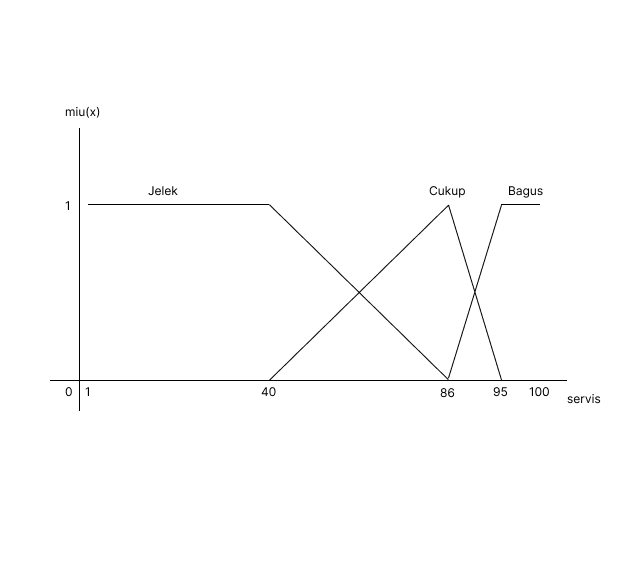

In [4]:
def fuzzServis(x):
  result = dict()
  if x >= 1 and x <= 40:
    result["Jelek"] = 1
    result["Cukup"] = 0
  elif x > 40 and x <= 86:
    result["Jelek"] = -1 * (x - 86) / (86 - 40)
    result["Cukup"] = (x - 40) / (86 - 40)
  elif x > 86 and x <= 95:
    result["Cukup"] = -1 * (x - 95) / (95 - 86)
    result["Bagus"] = (x - 86) / (95 - 86)
  elif x > 95 and x <= 100:
    result["Cukup"] = 0
    result["Bagus"] = 1

  return result

# fuzzServis(54)

#### Harga
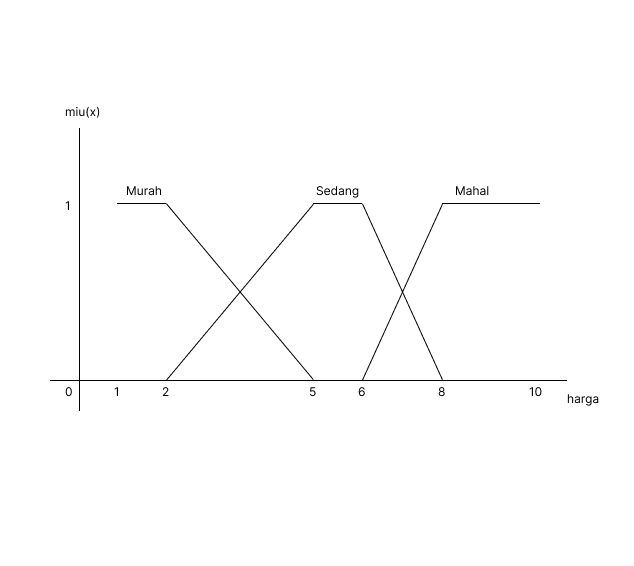

In [5]:
def fuzzHarga(x):
  result = dict()
  if x >= 1 and x <= 2:
    result["Murah"] = 1
    result["Sedang"] = 0
  if x > 2 and x <= 5:
    result["Murah"] = -1 * (x - 5) / (5 - 2)
    result["Sedang"] = (x - 2) / (5 - 2)
  elif x > 5 and x <= 6:
    result["Murah"] = 0
    result["Sedang"] = 1
  elif x > 6 and x <= 8:
    result["Sedang"] = -1 * (x - 8) / (8 - 6)
    result["Mahal"] = (x - 6) / (8 - 6)
  elif x > 8 and x <= 10:
    result["Sedang"] = 0
    result["Mahal"] = 1

  return result

# fuzzHarga(7)

### Inference

#### Fuzzy Rule

In [6]:
def fuzzRule(servis, harga):
  if servis == 'Jelek' and harga == 'Murah':
    return 'Rendah'
  elif servis == 'Jelek' and harga == 'Sedang':
    return 'Rendah'
  elif servis == 'Jelek' and harga == 'Mahal':
    return 'Rendah'
  elif servis == 'Cukup' and harga == 'Murah':
    return 'Tinggi'
  elif servis == 'Cukup' and harga == 'Sedang':
    return 'Rendah'
  elif servis == 'Cukup' and harga == 'Mahal':
    return 'Rendah'
  elif servis == 'Bagus' and harga == 'Murah':
    return 'Tinggi'
  elif servis == 'Bagus' and harga == 'Sedang':
    return 'Tinggi'
  elif servis == 'Bagus' and harga == 'Mahal':
    return 'Rendah'

#### Conjunction Combination of Fuzzy Input

In [7]:
def conj(servis, harga):
  result = []

  keyServis = list(servis.keys())
  keyHarga = list(harga.keys())

  for s in keyServis:
    for h in keyHarga:
      key = fuzzRule(s, h)
      value = min(servis[s], harga[h])
      result.append([key, value])

  return result

# conj(fuzzServis(58), fuzzHarga(7))

#### Disjunction Nilai Kelayakan

In [8]:
def disj(nilaiKelayakan):
  result = {'Rendah' : 0, 'Tinggi' : 0}

  # find maximum Rendah & Tinggi
  for arr in nilaiKelayakan:
    if arr[0] == 'Rendah':
      if arr[1] > result['Rendah']:
        result['Rendah'] = arr[1]
    elif arr[0] == 'Tinggi':
      if arr[1] > result['Tinggi']:
        result['Tinggi'] = arr[1]
    
  return result

# disj(conj(fuzzServis(58), fuzzHarga(7)))

### Defuzzification

#### Composition (Penggabungan 2 fuzzy set)

In [9]:
def fuzzCompos(x, fuzzOutput):
  if x >= 0 and x <= 50:
    rendah = fuzzOutput['Rendah']
    tinggi = 0
  elif x > 50 and x <= 80:
    rendah = -1 * (x - 80) / (80 - 50)
    if rendah > fuzzOutput['Rendah']:
      rendah = fuzzOutput['Rendah']
    tinggi = (x - 50) / (80 - 50)
    if tinggi > fuzzOutput['Tinggi']:
      tinggi = fuzzOutput['Tinggi']
  elif x > 80 and x <= 100:
    rendah = 0
    tinggi = fuzzOutput['Tinggi']

  return max(rendah, tinggi)

####  Centroid Method (Center of Gravity)

In [10]:
def centroid(fuzzOutput):
  numerator = 0
  denominator = 0
  for x in range(10, 101, 10):
    miu = fuzzCompos(x, fuzzOutput)
    numerator += (x * miu)
    denominator += miu
  
  return numerator / denominator

### Main


---

In [11]:
score = []
for idx in df.index:
  # fuzzification
  fuzzInputServis = fuzzServis(df['servis'][idx])
  fuzzInputHarga = fuzzHarga(df['harga'][idx])

  # inference
  nilaiKelayakan = conj(fuzzInputServis, fuzzInputHarga)
  fuzzOutput = disj(nilaiKelayakan)

  # defuzzification
  crispVal = centroid(fuzzOutput)
  score.append(crispVal)

df['score'] = score
df

,id,servis,harga,score
0,1,58,7,38.500000
1,2,54,1,46.344086
2,3,98,2,84.166667
3,4,52,4,45.694051
4,5,11,4,37.692308
...,...,...,...,...
95,96,30,1,35.555556
96,97,25,3,37.692308
97,98,27,10,35.555556
98,99,8,6,35.555556


## Menyimpan output ke file

In [12]:
df = df.sort_values(by='score', ascending=False)
df

,id,servis,harga,score
2,3,98,2,84.166667
90,91,98,3,82.222222
51,52,94,3,74.062500
33,34,93,4,68.108108
12,13,80,3,63.571429
...,...,...,...,...
32,33,33,8,35.555556
71,72,26,6,35.555556
72,73,22,10,35.555556
29,30,7,6,35.555556


In [13]:
df = df.head(10)
df.to_excel('peringkat.xlsx', index=False)

## 10 Bengkel Terbaik

In [14]:
df.head(10)

,id,servis,harga,score
2,3,98,2,84.166667
90,91,98,3,82.222222
51,52,94,3,74.062500
33,34,93,4,68.108108
12,13,80,3,63.571429
91,92,83,3,63.571429
16,17,70,3,62.777778
43,44,63,2,55.000000
74,75,61,1,52.948718
47,48,64,4,49.935065
